<a href="https://colab.research.google.com/github/Nadezda-Sut/statistics_in_science/blob/main/EI_conferemce_delite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


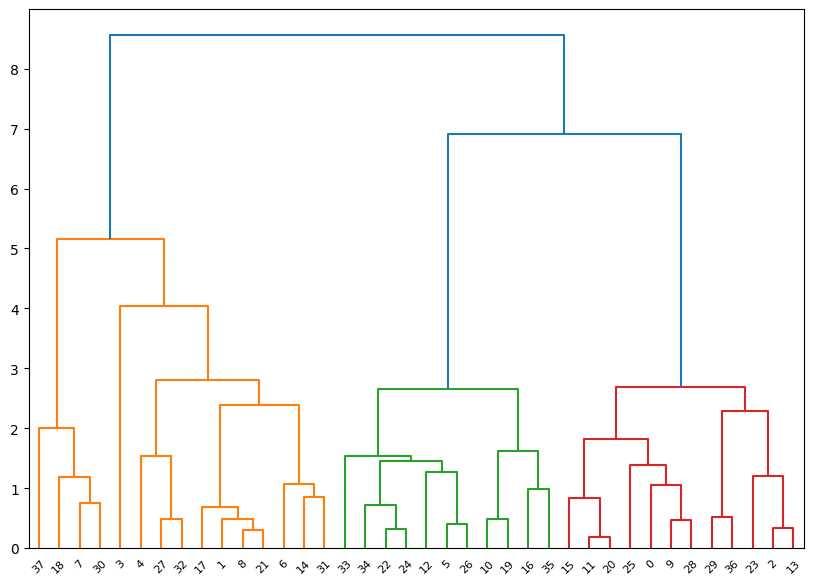

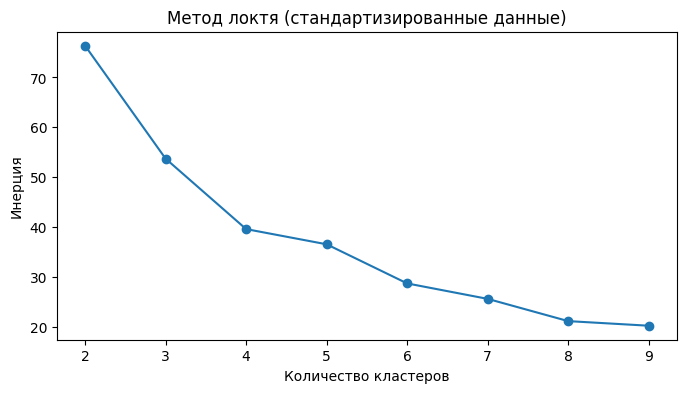

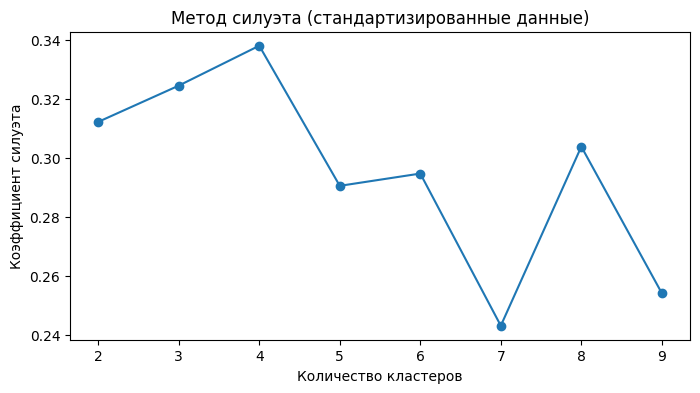

Participants in each cluster:
Cluster 0:
[ 2  4  5  7  8  9 15 18 19 22 28 31 32 33 38]
Cluster 1:
[ 1  3 10 12 14 16 21 24 26 29 30 37]
Cluster 2:
[ 6 11 13 17 20 23 25 27 34 35 36]
=== Kruskal-Wallis Test for Each Variable ===

Kruskal-Wallis test results for WMem: Количество объектов, серия 1: KruskalResult(statistic=23.327350862143486, pvalue=8.600627166111734e-06)

Pairwise comparisons (WMem: Количество объектов, серия 1):
Comparison: Cluster 1 vs Cluster 0 - WMem: Количество объектов, серия 1: U = 19.0, p-value = 0.001 (Significant)
Comparison: Cluster 1 vs Cluster 2 - WMem: Количество объектов, серия 1: U = 0.0, p-value = 0.000 (Significant)
Comparison: Cluster 0 vs Cluster 2 - WMem: Количество объектов, серия 1: U = 29.5, p-value = 0.006 (Significant)

Kruskal-Wallis test results for WMem: Количество объектов, серия 2: KruskalResult(statistic=15.404192351427389, pvalue=0.00045187897169935966)

Pairwise comparisons (WMem: Количество объектов, серия 2):
Comparison: Cluster 1 vs C

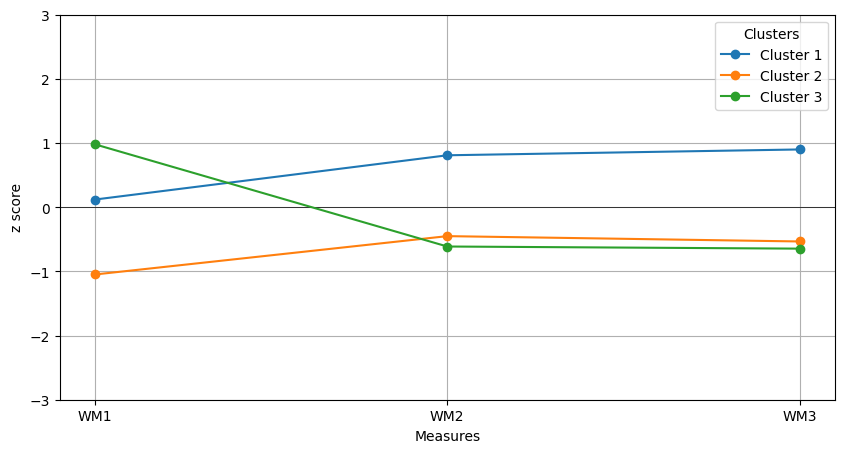

In [49]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from scipy.stats import kruskal, mannwhitneyu
from sklearn.decomposition import PCA

# Загрузка данных
file_path = "/content/gdrive/My Drive/working_memory/conference_without_blinks.csv"
data = pd.read_csv(file_path)

# Извлечение данных для анализа
variables = ['WMem: Количество объектов, серия 1',
             'WMem: Количество объектов, серия 2',
             'WMem: Количество объектов, серия 3']

X = data[variables].values

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Построение дендрограммы
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'))
plt.show()

# Определение оптимального количества кластеров методом локтя
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), inertia, marker='o')
plt.title("Метод локтя (стандартизированные данные)")
plt.xlabel("Количество кластеров")
plt.ylabel("Инерция")
plt.show()

# Определение оптимального количества кластеров методом силуэта
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title("Метод силуэта (стандартизированные данные)")
plt.xlabel("Количество кластеров")
plt.ylabel("Коэффициент силуэта")
plt.show()

# Оптимальное количество кластеров (например, 3)
optimal_clusters = 3

# Иерархическая кластеризация
agglo = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
clusters = agglo.fit_predict(X_scaled)



# Добавление кластеров в данные
data['Cluster'] = clusters

# Вывод номеров участников в каждом кластере
print("Participants in each cluster:")
for i in range(optimal_clusters):
    print(f"Cluster {i}:")
    print(data.loc[data['Cluster'] == i].iloc[:, 0].values)  # Предполагается, что ID участников в первом столбце

# Выполнение Kruskal-Wallis теста и парных сравнений
print("=== Kruskal-Wallis Test for Each Variable ===")
for column in variables:
    data_groups = [data[data['Cluster'] == i][column] for i in range(optimal_clusters)]
    kruskal_results = kruskal(*data_groups)
    print(f"\nKruskal-Wallis test results for {column}: {kruskal_results}")

    # Выполнение парных сравнений, если Kruskal-Wallis показывает значимость
    if kruskal_results.pvalue < 0.05:
        p_values = []
        clusters_unique = data['Cluster'].unique()
        for i in range(len(clusters_unique)):
            for j in range(i + 1, len(clusters_unique)):
                u_stat, p_val = mannwhitneyu(
                    data[data['Cluster'] == clusters_unique[i]][column],
                    data[data['Cluster'] == clusters_unique[j]][column]
                )
                p_values.append((f"Comparison: Cluster {clusters_unique[i]} vs Cluster {clusters_unique[j]} - {column}", u_stat, p_val))

        # Печать результатов парных сравнений
        print(f"\nPairwise comparisons ({column}):")
        for comparison, u_stat, p_value in p_values:
            significance = "Significant" if p_value < 0.05 else "Not Significant"
            print(f"{comparison}: U = {u_stat:.1f}, p-value = {p_value:.3f} ({significance})")

# Функция для визуализации Z-Score данных с диапазоном от -3 до 3
def plot_standardized_scores(profiles, measures):
    plt.figure(figsize=(10, 5))

    for profile_name, profile_data in profiles.items():
        mean_scores = np.mean(profile_data, axis=0)
        plt.errorbar(measures, mean_scores, label=profile_name, fmt='o-', capsize=5)

    plt.axhline(0, color='black', linewidth=0.5)
    plt.ylim(-3, 3)  # Ограничение диапазона оси Y от -3 до 3
    plt.xlabel('Measures')
    plt.ylabel('z score')
    plt.grid(True)
    plt.legend(title='Clusters')
    plt.show()

# Подготовка данных для построения графиков с короткими названиями
measures_short = ['WM1', 'WM2', 'WM3']  # Короткие названия для переменных

# Кластеры
profiles = {}
for i in range(optimal_clusters):
    profiles[f'Cluster {i+1}'] = X_scaled[clusters == i]

# Построение графиков Z-Score с короткими названиями
plot_standardized_scores(profiles, measures_short)



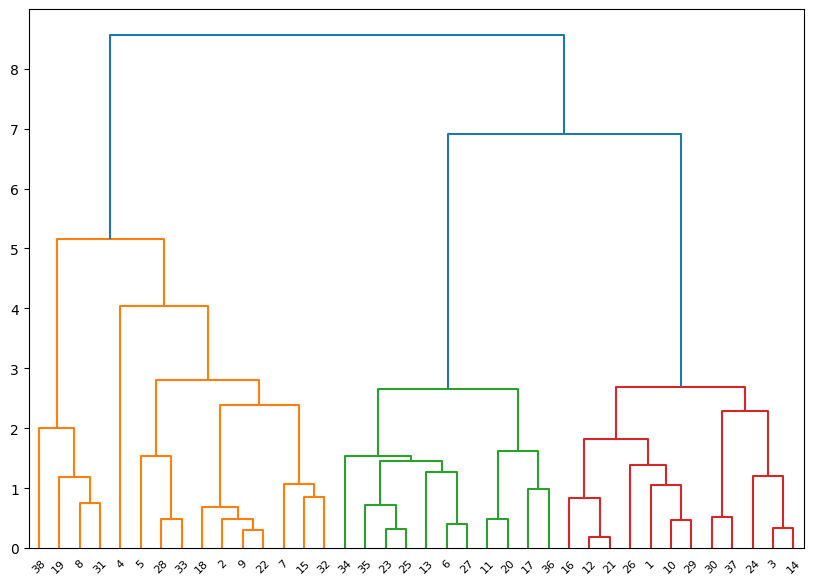

In [46]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

# Построение дендрограммы с сохранением информации о кластерах
linked = shc.linkage(X_scaled, method='ward')

plt.figure(figsize=(10, 7))
dend = shc.dendrogram(linked, labels=data.iloc[:, 0].values)  # Используйте идентификаторы участников как метки
plt.show()




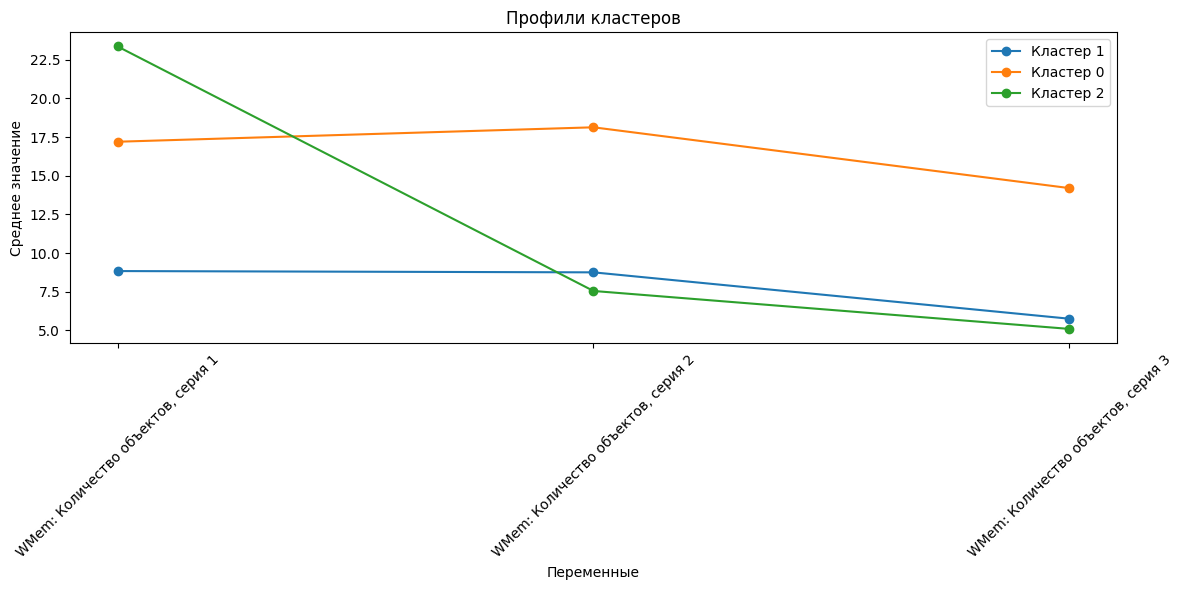

In [4]:
def plot_cluster_profiles(data, variables):
    clusters = data['Cluster'].unique()
    plt.figure(figsize=(12, 6))

    for cluster in clusters:
        cluster_data = data[data['Cluster'] == cluster]
        mean_scores = cluster_data[variables].mean()
        plt.plot(variables, mean_scores, marker='o', label=f'Кластер {cluster}')

    plt.title('Профили кластеров')
    plt.xlabel('Переменные')
    plt.ylabel('Среднее значение')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_cluster_profiles(data, variables)


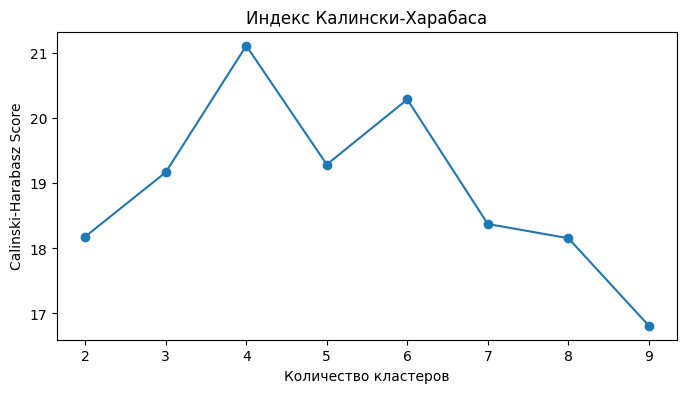

Оптимальное количество кластеров по индексу Калински-Харабаса: 4


In [20]:
from sklearn.metrics import calinski_harabasz_score

ch_scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = calinski_harabasz_score(X_scaled, labels)
    ch_scores.append(score)

# Построение графика
plt.figure(figsize=(8, 4))
plt.plot(K, ch_scores, marker='o')
plt.title("Индекс Калински-Харабаса")
plt.xlabel("Количество кластеров")
plt.ylabel("Calinski-Harabasz Score")
plt.show()

# Определение оптимального количества кластеров
optimal_k_ch = K[np.argmax(ch_scores)]
print(f"Оптимальное количество кластеров по индексу Калински-Харабаса: {optimal_k_ch}")


In [21]:
# Выполнение Kruskal-Wallis теста и парных сравнений с поправкой Бонферрони
print("=== Kruskal-Wallis Test for Each Variable ===")
for column in variables:
    data_groups = [data[data['Cluster'] == i][column] for i in range(optimal_clusters)]
    kruskal_results = kruskal(*data_groups)
    print(f"\nKruskal-Wallis test results for {column}: {kruskal_results}")

    # Выполнение парных сравнений, если Kruskal-Wallis показывает значимость
    if kruskal_results.pvalue < 0.05:
        p_values = []
        clusters_unique = data['Cluster'].unique()
        n_comparisons = int(len(clusters_unique) * (len(clusters_unique) - 1) / 2)  # Количество парных сравнений
        for i in range(len(clusters_unique)):
            for j in range(i + 1, len(clusters_unique)):
                u_stat, p_val = mannwhitneyu(
                    data[data['Cluster'] == clusters_unique[i]][column],
                    data[data['Cluster'] == clusters_unique[j]][column],
                    alternative='two-sided'
                )
                # Поправка Бонферрони
                p_val_adj = min(p_val * n_comparisons, 1.0)
                p_values.append((f"Сравнение: Кластер {clusters_unique[i]} vs Кластер {clusters_unique[j]} - {column}",
                                 u_stat, p_val, p_val_adj))

        # Печать результатов парных сравнений с поправкой Бонферрони
        print(f"\nПарные сравнения с поправкой Бонферрони ({column}):")
        for comparison, u_stat, p_value, p_value_adj in p_values:
            significance = "Значимо" if p_value_adj < 0.05 else "Не значимо"
            print(f"{comparison}: U = {u_stat:.1f}, p-value = {p_value:.3f}, скорректированное p-value = {p_value_adj:.3f} ({significance})")


=== Kruskal-Wallis Test for Each Variable ===

Kruskal-Wallis test results for WMem: Количество объектов, серия 1: KruskalResult(statistic=23.327350862143486, pvalue=8.600627166111734e-06)

Парные сравнения с поправкой Бонферрони (WMem: Количество объектов, серия 1):
Сравнение: Кластер 1 vs Кластер 0 - WMem: Количество объектов, серия 1: U = 19.0, p-value = 0.001, скорректированное p-value = 0.002 (Значимо)
Сравнение: Кластер 1 vs Кластер 2 - WMem: Количество объектов, серия 1: U = 0.0, p-value = 0.000, скорректированное p-value = 0.000 (Значимо)
Сравнение: Кластер 0 vs Кластер 2 - WMem: Количество объектов, серия 1: U = 29.5, p-value = 0.006, скорректированное p-value = 0.019 (Значимо)

Kruskal-Wallis test results for WMem: Количество объектов, серия 2: KruskalResult(statistic=15.404192351427389, pvalue=0.00045187897169935966)

Парные сравнения с поправкой Бонферрони (WMem: Количество объектов, серия 2):
Сравнение: Кластер 1 vs Кластер 0 - WMem: Количество объектов, серия 2: U = 23.0,

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# Загрузка данных
file_path = "/content/gdrive/My Drive/working_memory/conference_without_blinks.csv"
data = pd.read_csv(file_path)

# Список переменных для анализа
variables = ['WMem: Количество объектов, серия 1',
             'WMem: Количество объектов, серия 2',
             'WMem: Количество объектов, серия 3']

# Оптимальное количество кластеров (например, 3)
optimal_clusters = 3

# Стандартизация данных
X = data[variables].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Иерархическая кластеризация с использованием параметра `metric`
agglo = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
clusters = agglo.fit_predict(X_scaled)

# Добавление кластеров в данные
data['Cluster'] = clusters

# Создание DataFrame для хранения результатов
results = pd.DataFrame(columns=['Variable'] + [f'Cluster {i+1}' for i in range(optimal_clusters)])

for variable in variables:
    mean_std_list = []
    for i in range(optimal_clusters):
        cluster_data = data[data['Cluster'] == i][variable]
        mean = cluster_data.mean()
        std = cluster_data.std()
        mean_std_list.append(f'{mean:.2f} ± {std:.2f}')

    new_row = pd.DataFrame({
        'Variable': [variable],
        **{f'Cluster {i+1}': [mean_std_list[i]] for i in range(optimal_clusters)}
    })
    results = pd.concat([results, new_row], ignore_index=True)

# Сохранение результатов в CSV файл
output_file_path = "/content/gdrive/My Drive/working_memory/cluster_means_std.csv"
results.to_csv(output_file_path, index=False)

print(f"Результаты сохранены в файл: {output_file_path}")


Результаты сохранены в файл: /content/gdrive/My Drive/working_memory/cluster_means_std.csv


In [11]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, kruskal

# Выполнение Kruskal-Wallis теста и парных сравнений с поправкой Бонферрони
columns = ['Variable', 'Cluster 1 - 2', 'Cluster 1 - 3', 'Cluster 2 - 3']
results = []

for column in variables:
    data_groups = [data[data['Cluster'] == i][column] for i in range(optimal_clusters)]
    kruskal_results = kruskal(*data_groups)

    # Выполнение парных сравнений, если Kruskal-Wallis показывает значимость
    row = [column]
    if kruskal_results.pvalue < 0.05:
        clusters_unique = data['Cluster'].unique()
        n_comparisons = int(len(clusters_unique) * (len(clusters_unique) - 1) / 2)  # Количество парных сравнений
        comparisons = [(0, 1), (0, 2), (1, 2)]
        for (i, j) in comparisons:
            u_stat, p_val = mannwhitneyu(
                data[data['Cluster'] == i][column],
                data[data['Cluster'] == j][column],
                alternative='two-sided'
            )
            # Поправка Бонферрони
            p_val_adj = min(p_val * n_comparisons, 1.0)
            r_value = u_stat / (len(data[data['Cluster'] == i]) * len(data[data['Cluster'] == j]))

            comparison_result = f"U = {u_stat:.2f}, p = {p_val_adj:.3f}, r = {r_value:.3f}"
            row.append(comparison_result)
    else:
        row.extend(['-' for _ in range(3)])  # Если Kruskal-Wallis не значимый, ставим прочерки
    results.append(row)

# Преобразование результатов в DataFrame
results_df = pd.DataFrame(results, columns=columns)

# Сохранение результатов в CSV файл
output_file_path = "/content/gdrive/My Drive/working_memory/cluster_posthoc_results.csv"
results_df.to_csv(output_file_path, index=False)

print(f"Результаты сохранены в файл: {output_file_path}")


Результаты сохранены в файл: /content/gdrive/My Drive/working_memory/cluster_posthoc_results.csv


In [12]:
import pandas as pd
from scipy.stats import kruskal

# Список переменных для анализа
variables = ['WMem: Количество объектов, серия 1',
             'WMem: Количество объектов, серия 2',
             'WMem: Количество объектов, серия 3']

# Оптимальное количество кластеров
optimal_clusters = 3

# Создание DataFrame для хранения результатов Kruskal-Wallis теста
kruskal_results_df = pd.DataFrame(columns=['Variable', 'Kruskal-Wallis-H, p-value'])

# Проведение Kruskal-Wallis теста для каждой переменной
for column in variables:
    data_groups = [data[data['Cluster'] == i][column] for i in range(optimal_clusters)]
    kruskal_results = kruskal(*data_groups)

    # Форматирование результата в требуемом виде
    p_value = "< 0.01" if kruskal_results.pvalue < 0.01 else f'{kruskal_results.pvalue:.2f}'
    result_str = f'{kruskal_results.statistic:.2f}, p {p_value}'

    # Подготовка новой строки с результатами
    new_row = pd.DataFrame({
        'Variable': [column],
        'Kruskal-Wallis-H, p-value': [result_str]
    })

    # Добавление новой строки в DataFrame
    kruskal_results_df = pd.concat([kruskal_results_df, new_row], ignore_index=True)

# Сохранение результатов в CSV файл
output_file_path = "/content/gdrive/My Drive/working_memory/kruskal_wallis_results_formatted.csv"
kruskal_results_df.to_csv(output_file_path, index=False)

print(f"Результаты Kruskal-Wallis теста сохранены в файл: {output_file_path}")


Результаты Kruskal-Wallis теста сохранены в файл: /content/gdrive/My Drive/working_memory/kruskal_wallis_results_formatted.csv


In [67]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, kruskal

# Выполнение Kruskal-Wallis теста и парных сравнений с поправкой Бонферрони
columns = ['Variable', 'Cluster 1 - 2', 'Cluster 1 - 3', 'Cluster 2 - 3']
results = []

for column in variables:
    data_groups = [data[data['Cluster'] == i][column] for i in range(optimal_clusters)]
    kruskal_results = kruskal(*data_groups)

    # Выполнение парных сравнений, если Kruskal-Wallis показывает значимость
    row = [column]
    if kruskal_results.pvalue < 0.05:
        clusters_unique = data['Cluster'].unique()
        n_comparisons = int(len(clusters_unique) * (len(clusters_unique) - 1) / 2)  # Количество парных сравнений
        comparisons = [(0, 1), (0, 2), (1, 2)]
        for (i, j) in comparisons:
            u_stat, p_val = mannwhitneyu(
                data[data['Cluster'] == i][column],
                data[data['Cluster'] == j][column],
                alternative='two-sided'
            )
            # Поправка Бонферрони
            p_val_adj = min(p_val * n_comparisons, 1.0)
            r_value = u_stat / (len(data[data['Cluster'] == i]) * len(data[data['Cluster'] == j]))

            # Форматирование p-value
            if p_val_adj < 0.01:
                p_val_str = "p<0.01"
            elif p_val_adj < 0.05:
                p_val_str = "p<0.05"
            else:
                p_val_str = "p>0.05"

            comparison_result = f"U = {u_stat:.2f}, {p_val_str}, r = {r_value:.3f}"
            row.append(comparison_result)
    else:
        row.extend(['-' for _ in range(3)])  # Если Kruskal-Wallis не значимый, ставим прочерки
    results.append(row)

# Преобразование результатов в DataFrame
results_df = pd.DataFrame(results, columns=columns)

# Сохранение результатов в CSV файл
output_file_path = "/content/gdrive/My Drive/working_memory/cluster_posthoc_results.csv"
results_df.to_csv(output_file_path, index=False)

print(f"Результаты сохранены в файл: {output_file_path}")


Результаты сохранены в файл: /content/gdrive/My Drive/working_memory/cluster_posthoc_results.csv


In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import kruskal, chi2_contingency

# Загрузка данных
file_path = "/content/gdrive/My Drive/working_memory/conference_without_blinks.csv"
data = pd.read_csv(file_path)

# Выбор переменных для кластеризации
cluster_variables = ['WMem: Количество объектов, серия 1',
                     'WMem: Количество объектов, серия 2',
                     'WMem: Количество объектов, серия 3']

# Стандартизация данных для кластеризации
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[cluster_variables].values)

# Иерархическая кластеризация (используем оптимальное число кластеров - 3)
optimal_clusters = 3
agglo = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
clusters = agglo.fit_predict(X_scaled)

# Добавление кластеров в исходные данные
data['Cluster'] = clusters

# Переменные, которые вы хотите проанализировать
variables_of_interest = [
    'WMem: Количество объектов, серия 1',
    'WMem: Количество объектов, серия 2',
    'WMem: Количество объектов, серия 3',
    'Time-test: Ош 2 1',
    'Time-test: Ош 2 2',
    'Сколько лет вашему ребенку, принимавшему участие в исследовании ?',
    'пол',
    'У вашего ребёнка есть собственные цифровые устройства?',
    'будние дни',
    'Выходные'
]

# Создание пустого DataFrame для хранения результатов
cluster_stats = pd.DataFrame(index=variables_of_interest, columns=[f"Cluster {i+1}" for i in range(optimal_clusters)] + ['p-value'])

# Вычисление средних значений и стандартных отклонений по каждому кластеру
for var in variables_of_interest:
    if data[var].dtype in [np.float64, np.int64]:  # Для числовых переменных
        for i in range(optimal_clusters):
            cluster_data = data[data['Cluster'] == i][var]
            mean = cluster_data.mean()
            std = cluster_data.std()
            cluster_stats.loc[var, f"Cluster {i+1}"] = f"{mean:.2f} ± {std:.2f}"

        # Крускал-Уоллис для числовых переменных
        groups = [data[data['Cluster'] == i][var] for i in range(optimal_clusters)]
        stat, p = kruskal(*groups)
        cluster_stats.loc[var, 'p-value'] = p

    else:  # Для категориальных переменных
        contingency_table = pd.crosstab(data['Cluster'], data[var])
        stat, p, _, _ = chi2_contingency(contingency_table)
        cluster_stats.loc[var, 'p-value'] = p

# Добавление значимости
significance_level = 0.05
cluster_stats['Significant'] = cluster_stats['p-value'].apply(lambda p: 'Yes' if p < significance_level else 'No')

# Сохранение результатов в CSV файл
output_file = "/content/gdrive/My Drive/working_memory/cluster_statistics_selected_variables.csv"
cluster_stats.to_csv(output_file, encoding='utf-8')

print(f"Результаты успешно сохранены в файл {output_file}")


Результаты успешно сохранены в файл /content/gdrive/My Drive/working_memory/cluster_statistics_selected_variables.csv


In [70]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, kruskal

# Определение переменных для анализа
variables = [
    'WMem: Количество объектов, серия 1',
    'WMem: Количество объектов, серия 2',
    'WMem: Количество объектов, серия 3',
    'Time-test: Ош 2 1',
    'Time-test: Ош 2 2',
    'Сколько лет вашему ребенку, принимавшему участие в исследовании ?'  # Новая переменная
]

# Выполнение Kruskal-Wallis теста и парных сравнений с поправкой Бонферрони
columns = ['Variable', 'Cluster 1 - 2', 'Cluster 1 - 3', 'Cluster 2 - 3']
results = []

for column in variables:
    data_groups = [data[data['Cluster'] == i][column] for i in range(optimal_clusters)]
    kruskal_results = kruskal(*data_groups)

    # Выполнение парных сравнений, если Kruskal-Wallis показывает значимость
    row = [column]
    if kruskal_results.pvalue < 0.05:
        clusters_unique = data['Cluster'].unique()
        n_comparisons = int(len(clusters_unique) * (len(clusters_unique) - 1) / 2)  # Количество парных сравнений
        comparisons = [(0, 1), (0, 2), (1, 2)]
        for (i, j) in comparisons:
            u_stat, p_val = mannwhitneyu(
                data[data['Cluster'] == i][column],
                data[data['Cluster'] == j][column],
                alternative='two-sided'
            )
            # Поправка Бонферрони
            p_val_adj = min(p_val * n_comparisons, 1.0)
            r_value = u_stat / (len(data[data['Cluster'] == i]) * len(data[data['Cluster'] == j]))

            # Форматирование p-value
            if p_val_adj < 0.01:
                p_val_str = "p<0.01"
            elif p_val_adj < 0.05:
                p_val_str = "p<0.05"
            else:
                p_val_str = "p>0.05"

            comparison_result = f"U = {u_stat:.2f}, {p_val_str}, r = {r_value:.3f}"
            row.append(comparison_result)
    else:
        row.extend(['-' for _ in range(3)])  # Если Kruskal-Wallis не значимый, ставим прочерки
    results.append(row)

# Преобразование результатов в DataFrame
results_df = pd.DataFrame(results, columns=columns)

# Сохранение результатов в CSV файл
output_file_path = "/content/gdrive/My Drive/working_memory/cluster_posthoc_results.csv"
results_df.to_csv(output_file_path, index=False)

print(f"Результаты сохранены в файл: {output_file_path}")


Результаты сохранены в файл: /content/gdrive/My Drive/working_memory/cluster_posthoc_results.csv


In [51]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal, chi2_contingency, mannwhitneyu
import itertools

# Загрузка данных
file_path = "/content/gdrive/My Drive/working_memory/conference_without_blinks.csv"
data = pd.read_csv(file_path)

# Добавление кластеров из предыдущего анализа
data['Cluster'] = clusters

# Переменные для анализа
kruskal_variables = [
    'WMem: Количество объектов, серия 1',
    'WMem: Количество объектов, серия 2',
    'WMem: Количество объектов, серия 3',
    'Time-test: Ош 2 1',
    'Time-test: Ош 2 2',
    'Time-test: Проп 1 1',
    'Time-test: Количество пропусков, серия 1 (Часть 2)',
    'Time-test: Количество пропусков, серия 2 (Часть 1)',
    'Time-test: Количество пропусков, серия 2 (Часть 2)',
    'Сколько лет вашему ребенку, принимавшему участие в исследовании ?',
    'будние дни',
    'Выходные'
]

binary_variables = ['пол', 'У вашего ребёнка есть собственные цифровые устройства?']

# Проверка различий для каждой переменной
results = {}

# Непрерывные переменные и шкала Лайкерта - Крускал-Уоллис
for var in kruskal_variables:
    groups = [data[data['Cluster'] == i][var] for i in range(optimal_clusters)]
    stat, p = kruskal(*groups)
    results[var] = {'Test': 'Kruskal-Wallis', 'Statistic': stat, 'p-value': p}

# Бинарные переменные - Хи-квадрат
for var in binary_variables:
    contingency_table = pd.crosstab(data['Cluster'], data[var])
    stat, p, _, _ = chi2_contingency(contingency_table)
    results[var] = {'Test': 'Chi-Square', 'Statistic': stat, 'p-value': p}

# Печать результатов
for var, result in results.items():
    print(f"Variable: {var}")
    print(f"Test: {result['Test']}")
    print(f"Statistic: {result.get('Statistic', 'N/A')}")
    print(f"p-value: {result['p-value']}")
    print("\n")

# Проводим парные сравнения после Крускала-Уоллиса с использованием теста Манна-Уитни
pairwise_results = {}

for var in kruskal_variables:
    pairs = list(itertools.combinations(range(optimal_clusters), 2))  # Список всех возможных пар кластеров
    pairwise_pvalues = []
    for (i, j) in pairs:
        group1 = data[data['Cluster'] == i][var]
        group2 = data[data['Cluster'] == j][var]
        stat, p = mannwhitneyu(group1, group2)
        pairwise_pvalues.append((f"Cluster {i+1} vs Cluster {j+1}", p))

    pairwise_results[var] = pairwise_pvalues

# Печать результатов парных сравнений
for var, comparisons in pairwise_results.items():
    print(f"Pairwise comparisons for variable: {var}")
    for comparison, p in comparisons:
        print(f"{comparison}: p-value = {p:.4f}")
    print("\n")


Variable: WMem: Количество объектов, серия 1
Test: Kruskal-Wallis
Statistic: 23.327350862143486
p-value: 8.600627166111734e-06


Variable: WMem: Количество объектов, серия 2
Test: Kruskal-Wallis
Statistic: 15.404192351427389
p-value: 0.00045187897169935966


Variable: WMem: Количество объектов, серия 3
Test: Kruskal-Wallis
Statistic: 19.579322716749687
p-value: 5.602786742741088e-05


Variable: Time-test: Ош 2 1
Test: Kruskal-Wallis
Statistic: 0.6890692759922812
p-value: 0.7085500090092963


Variable: Time-test: Ош 2 2
Test: Kruskal-Wallis
Statistic: 0.5748623729017501
p-value: 0.7501881881065731


Variable: Time-test: Проп 1 1
Test: Kruskal-Wallis
Statistic: 1.5673904228290705
p-value: 0.4567152300008541


Variable: Time-test: Количество пропусков, серия 1 (Часть 2)
Test: Kruskal-Wallis
Statistic: 0.4700881406994324
p-value: 0.7905360096626275


Variable: Time-test: Количество пропусков, серия 2 (Часть 1)
Test: Kruskal-Wallis
Statistic: 3.4416236765543946
p-value: 0.17892083415208557


In [71]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal, chi2_contingency, mannwhitneyu
import itertools

# Загрузка данных
file_path = "/content/gdrive/My Drive/working_memory/conference_without_blinks.csv"
data = pd.read_csv(file_path)

# Добавление кластеров из предыдущего анализа
data['Cluster'] = clusters

# Переменные для анализа
kruskal_variables = [
    'WMem: Количество объектов, серия 1',
    'WMem: Количество объектов, серия 2',
    'WMem: Количество объектов, серия 3',
    'Time-test: Ош 2 1',
    'Time-test: Ош 2 2',
    'Time-test: Проп 1 1',
    'Time-test: Количество пропусков, серия 1 (Часть 2)',
    'Time-test: Количество пропусков, серия 2 (Часть 1)',
    'Time-test: Количество пропусков, серия 2 (Часть 2)',
    'Сколько лет вашему ребенку, принимавшему участие в исследовании ?',
    'будние дни',
    'Выходные'
]

binary_variables = ['пол', 'У вашего ребёнка есть собственные цифровые устройства?']

# Проверка различий для каждой переменной
results = {}

# Непрерывные переменные и шкала Лайкерта - Крускал-Уоллис
for var in kruskal_variables:
    groups = [data[data['Cluster'] == i][var] for i in range(optimal_clusters)]
    stat, p = kruskal(*groups)
    results[var] = {'Test': 'Kruskal-Wallis', 'Statistic': stat, 'p-value': p}

# Бинарные переменные - Хи-квадрат
for var in binary_variables:
    contingency_table = pd.crosstab(data['Cluster'], data[var])
    stat, p, _, _ = chi2_contingency(contingency_table)
    results[var] = {'Test': 'Chi-Square', 'Statistic': stat, 'p-value': p}

# Печать результатов
for var, result in results.items():
    print(f"Variable: {var}")
    print(f"Test: {result['Test']}")
    print(f"Statistic: {result.get('Statistic', 'N/A')}")
    print(f"p-value: {result['p-value']}")
    print("\n")

# Проводим парные сравнения после Крускала-Уоллиса с использованием теста Манна-Уитни с поправкой Бонферрони
pairwise_results = {}

for var in kruskal_variables:
    pairs = list(itertools.combinations(range(optimal_clusters), 2))  # Список всех возможных пар кластеров
    pairwise_pvalues = []
    n_comparisons = len(pairs)  # Количество парных сравнений
    for (i, j) in pairs:
        group1 = data[data['Cluster'] == i][var]
        group2 = data[data['Cluster'] == j][var]
        stat, p = mannwhitneyu(group1, group2)
        p_adj = min(p * n_comparisons, 1.0)  # Поправка Бонферрони
        pairwise_pvalues.append((f"Cluster {i+1} vs Cluster {j+1}", p_adj))

    pairwise_results[var] = pairwise_pvalues

# Печать результатов парных сравнений
for var, comparisons in pairwise_results.items():
    print(f"Pairwise comparisons for variable: {var}")
    for comparison, p in comparisons:
        print(f"{comparison}: p-value = {p:.4f}")
    print("\n")


Variable: WMem: Количество объектов, серия 1
Test: Kruskal-Wallis
Statistic: 23.327350862143486
p-value: 8.600627166111734e-06


Variable: WMem: Количество объектов, серия 2
Test: Kruskal-Wallis
Statistic: 15.404192351427389
p-value: 0.00045187897169935966


Variable: WMem: Количество объектов, серия 3
Test: Kruskal-Wallis
Statistic: 19.579322716749687
p-value: 5.602786742741088e-05


Variable: Time-test: Ош 2 1
Test: Kruskal-Wallis
Statistic: 0.6890692759922812
p-value: 0.7085500090092963


Variable: Time-test: Ош 2 2
Test: Kruskal-Wallis
Statistic: 0.5748623729017501
p-value: 0.7501881881065731


Variable: Time-test: Проп 1 1
Test: Kruskal-Wallis
Statistic: 1.5673904228290705
p-value: 0.4567152300008541


Variable: Time-test: Количество пропусков, серия 1 (Часть 2)
Test: Kruskal-Wallis
Statistic: 0.4700881406994324
p-value: 0.7905360096626275


Variable: Time-test: Количество пропусков, серия 2 (Часть 1)
Test: Kruskal-Wallis
Statistic: 3.4416236765543946
p-value: 0.17892083415208557


<ipython-input-64-163094cabee7>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster',


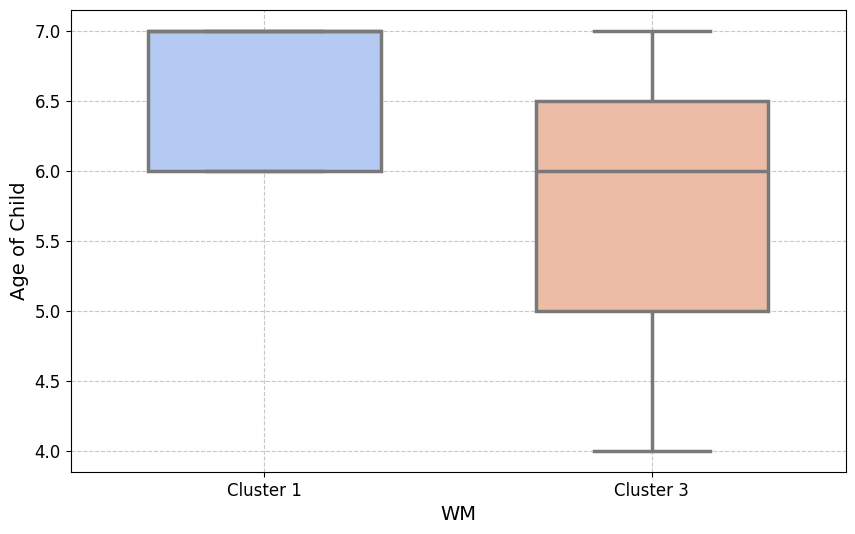

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

# Отфильтровываем данные только для кластеров 1 и 3
filtered_data = data[data['Cluster'].isin([0, 2])]  # Cluster 1 - это индекс 0, Cluster 3 - это индекс 2

# Визуализация различий между кластерами 1 и 3 для переменной "Сколько лет вашему ребенку, принимавшему участие в исследовании ?"
plt.figure(figsize=(10, 6))

# Настройка боксовой диаграммы
sns.boxplot(x='Cluster',
            y='Сколько лет вашему ребенку, принимавшему участие в исследовании ?',
            data=filtered_data,
            palette="coolwarm",  # Применение цветовой палитры
            width=0.6,  # Сделаем боксы немного уже
            linewidth=2.5)  # Толщина линий боксов

# Добавление медианы и размахов
# plt.title('Age of Children: Cluster 1 vs Cluster 3', fontsize=16, fontweight='bold')
plt.xlabel('WM', fontsize=14)
plt.ylabel('Age of Child', fontsize=14)
plt.xticks([0, 1], ['Cluster 1', 'Cluster 3'], fontsize=12)  # Обновляем подписи осей для соответствия кластерам
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)  # Легкая сетка для удобства восприятия
plt.show()


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


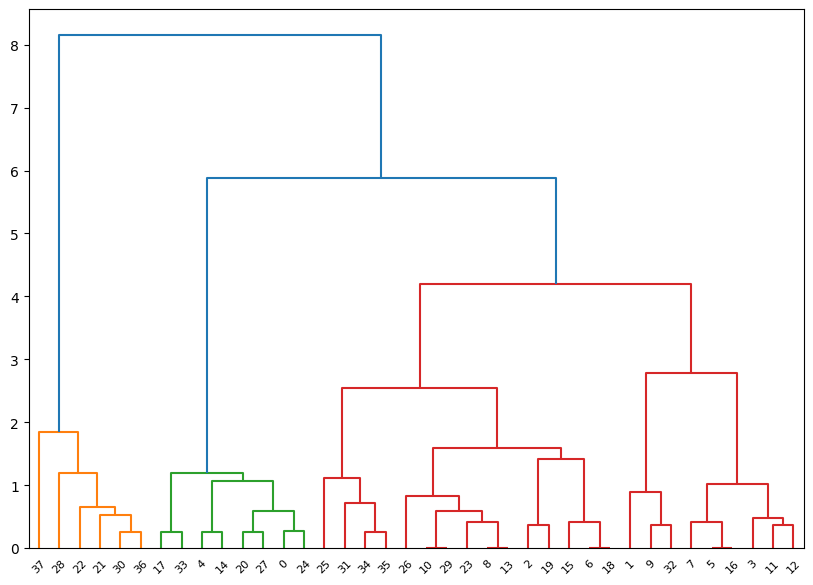

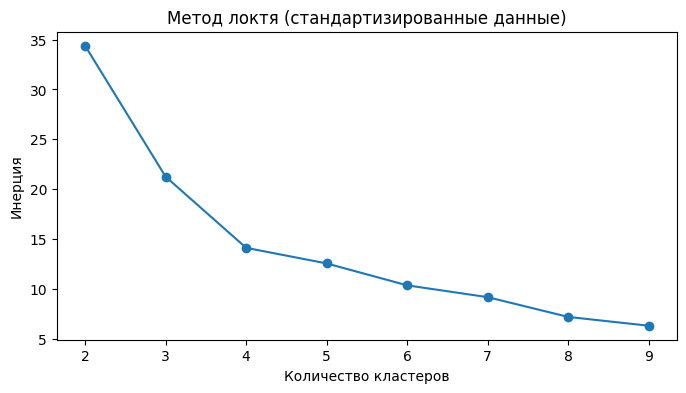

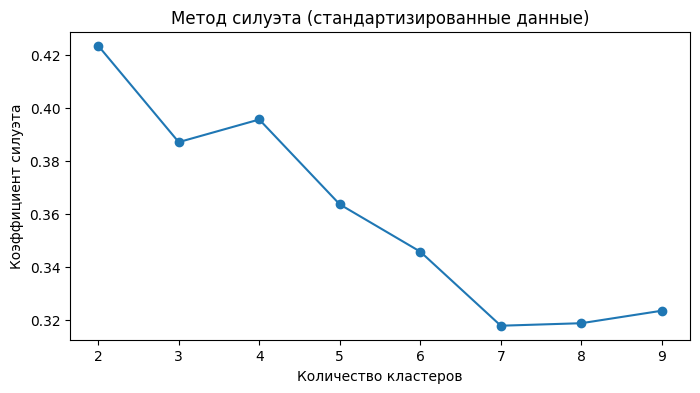

Participants in each cluster:
Cluster 0:
[ 2  4  6  8 10 12 13 17 33]
Cluster 1:
[ 3  7  9 11 14 16 19 20 24 26 27 30 32 35 36]
Cluster 2:
[ 1  5 15 18 21 25 28 34]
Cluster 3:
[22 23 29 31 37 38]
=== Kruskal-Wallis Test for Each Variable ===

Kruskal-Wallis test results for Time-test: Ош 2 1: KruskalResult(statistic=26.650010557820153, pvalue=6.97071102295193e-06)

Pairwise comparisons (Time-test: Ош 2 1):
Comparison: Cluster 2 vs Cluster 0 - Time-test: Ош 2 1: U = 3.5, p-value = 0.002 (Significant)
Comparison: Cluster 2 vs Cluster 1 - Time-test: Ош 2 1: U = 0.0, p-value = 0.000 (Significant)
Comparison: Cluster 2 vs Cluster 3 - Time-test: Ош 2 1: U = 0.0, p-value = 0.002 (Significant)
Comparison: Cluster 0 vs Cluster 1 - Time-test: Ош 2 1: U = 80.0, p-value = 0.469 (Not Significant)
Comparison: Cluster 0 vs Cluster 3 - Time-test: Ош 2 1: U = 0.0, p-value = 0.002 (Significant)
Comparison: Cluster 1 vs Cluster 3 - Time-test: Ош 2 1: U = 0.0, p-value = 0.000 (Significant)

Kruskal-Wallis

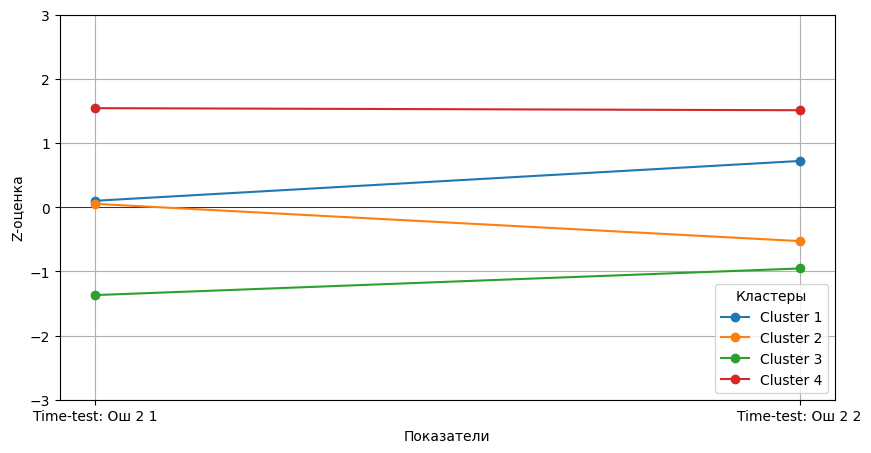

In [78]:
# Подключение к Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from scipy.stats import kruskal, mannwhitneyu
from sklearn.decomposition import PCA

# Загрузка данных
file_path = "/content/gdrive/My Drive/working_memory/conference_without_blinks.csv"
data = pd.read_csv(file_path)

# Извлечение данных для анализа
variables = ['Time-test: Ош 2 1',
             'Time-test: Ош 2 2',]

X = data[variables].values

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Построение дендрограммы
plt.figure(figsize=(10, 7))
dend = shc.dendrogram(shc.linkage(X_scaled, method='ward'))
plt.show()

# Определение оптимального количества кластеров методом локтя
inertia = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), inertia, marker='o')
plt.title("Метод локтя (стандартизированные данные)")
plt.xlabel("Количество кластеров")
plt.ylabel("Инерция")
plt.show()

# Определение оптимального количества кластеров методом силуэта
silhouette_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title("Метод силуэта (стандартизированные данные)")
plt.xlabel("Количество кластеров")
plt.ylabel("Коэффициент силуэта")
plt.show()

# Оптимальное количество кластеров (например, 3)
optimal_clusters = 4

# Иерархическая кластеризация
agglo = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
clusters = agglo.fit_predict(X_scaled)



# Добавление кластеров в данные
data['Cluster'] = clusters

# Вывод номеров участников в каждом кластере
print("Participants in each cluster:")
for i in range(optimal_clusters):
    print(f"Cluster {i}:")
    print(data.loc[data['Cluster'] == i].iloc[:, 0].values)  # Предполагается, что ID участников в первом столбце

# Выполнение Kruskal-Wallis теста и парных сравнений
print("=== Kruskal-Wallis Test for Each Variable ===")
for column in variables:
    data_groups = [data[data['Cluster'] == i][column] for i in range(optimal_clusters)]
    kruskal_results = kruskal(*data_groups)
    print(f"\nKruskal-Wallis test results for {column}: {kruskal_results}")

    # Выполнение парных сравнений, если Kruskal-Wallis показывает значимость
    if kruskal_results.pvalue < 0.05:
        p_values = []
        clusters_unique = data['Cluster'].unique()
        for i in range(len(clusters_unique)):
            for j in range(i + 1, len(clusters_unique)):
                u_stat, p_val = mannwhitneyu(
                    data[data['Cluster'] == clusters_unique[i]][column],
                    data[data['Cluster'] == clusters_unique[j]][column]
                )
                p_values.append((f"Comparison: Cluster {clusters_unique[i]} vs Cluster {clusters_unique[j]} - {column}", u_stat, p_val))

        # Печать результатов парных сравнений
        print(f"\nPairwise comparisons ({column}):")
        for comparison, u_stat, p_value in p_values:
            significance = "Significant" if p_value < 0.05 else "Not Significant"
            print(f"{comparison}: U = {u_stat:.1f}, p-value = {p_value:.3f} ({significance})")

# Функция для визуализации Z-Score данных с диапазоном от -3 до 3
def plot_standardized_scores(profiles, measures):
    plt.figure(figsize=(10, 5))

    for profile_name, profile_data in profiles.items():
        mean_scores = np.mean(profile_data, axis=0)
        plt.errorbar(measures, mean_scores, label=profile_name, fmt='o-', capsize=5)

    plt.axhline(0, color='black', linewidth=0.5)
    plt.ylim(-3, 3)  # Ограничение диапазона оси Y от -3 до 3
    plt.xlabel('Показатели')
    plt.ylabel('Z-оценка')
    plt.grid(True)
    plt.legend(title='Кластеры')
    plt.show()

# Подготовка данных для построения графиков
measures = ['Time-test: Ош 2 1',
             'Time-test: Ош 2 2',]

# Кластеры
profiles = {}
for i in range(optimal_clusters):
    profiles[f'Cluster {i+1}'] = X_scaled[clusters == i]

# Построение графиков Z-Score
plot_standardized_scores(profiles, measures)


In [77]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, kruskal
import itertools

# Загрузка данных
file_path = "/content/gdrive/My Drive/working_memory/conference_without_blinks.csv"
data = pd.read_csv(file_path)

# Кластеры из предыдущего анализа
optimal_clusters = 4
data['Cluster'] = clusters

# Переменные для анализа
variables_of_interest = ['будние дни', 'Выходные']

# Проведение Kruskal-Wallis теста и парных сравнений без поправки Бонферрони
columns = ['Variable', 'Cluster 1 vs 2', 'Cluster 1 vs 3', 'Cluster 1 vs 4',
           'Cluster 2 vs 3', 'Cluster 2 vs 4', 'Cluster 3 vs 4']
results = []

for var in variables_of_interest:
    row = [var]
    # Kruskal-Wallis тест
    data_groups = [data[data['Cluster'] == i][var] for i in range(optimal_clusters)]
    kruskal_results = kruskal(*data_groups)

    # Если Kruskal-Wallis значимый, проводим парные сравнения
    if kruskal_results.pvalue < 0.05:
        pairs = list(itertools.combinations(range(optimal_clusters), 2))  # Список всех возможных пар кластеров
        for (i, j) in pairs:
            group1 = data[data['Cluster'] == i][var]
            group2 = data[data['Cluster'] == j][var]
            u_stat, p_val = mannwhitneyu(group1, group2)
            comparison_result = f"U = {u_stat:.2f}, p = {p_val:.4f}"
            row.append(comparison_result)
    else:
        row.extend(['-' for _ in range(6)])  # Если Kruskal-Wallis не значимый, ставим прочерки
    results.append(row)

# Преобразование результатов в DataFrame
results_df = pd.DataFrame(results, columns=columns)

# Сохранение результатов в CSV файл
output_file_path = "/content/gdrive/My Drive/working_memory/posthoc_mannwhitney_results.csv"
results_df.to_csv(output_file_path, index=False)

print(f"Результаты сохранены в файл: {output_file_path}")


Результаты сохранены в файл: /content/gdrive/My Drive/working_memory/posthoc_mannwhitney_results.csv


In [32]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal, chi2_contingency, mannwhitneyu
import itertools

# Загрузка данных
file_path = "/content/gdrive/My Drive/working_memory/conference_without_blinks.csv"
data = pd.read_csv(file_path)

# Добавление кластеров из предыдущего анализа
data['Cluster'] = clusters

# Переменные для анализа
kruskal_variables = [
    'WMem: Количество объектов, серия 1',
    'WMem: Количество объектов, серия 2',
    'WMem: Количество объектов, серия 3',
    'Time-test: Ош 2 1',
    'Time-test: Ош 2 2',
    'Time-test: Проп 1 1',
    'Time-test: Количество пропусков, серия 1 (Часть 2)',
    'Time-test: Количество пропусков, серия 2 (Часть 1)',
    'Time-test: Количество пропусков, серия 2 (Часть 2)',
    'Сколько лет вашему ребенку, принимавшему участие в исследовании ?',
    'будние дни',
    'Выходные'
]

binary_variables = ['пол', 'У вашего ребёнка есть собственные цифровые устройства?']

# Проверка различий для каждой переменной
results = {}

# Непрерывные переменные и шкала Лайкерта - Крускал-Уоллис
for var in kruskal_variables:
    groups = [data[data['Cluster'] == i][var] for i in range(optimal_clusters)]
    stat, p = kruskal(*groups)
    results[var] = {'Test': 'Kruskal-Wallis', 'Statistic': stat, 'p-value': p}

# Бинарные переменные - Хи-квадрат
for var in binary_variables:
    contingency_table = pd.crosstab(data['Cluster'], data[var])
    stat, p, _, _ = chi2_contingency(contingency_table)
    results[var] = {'Test': 'Chi-Square', 'Statistic': stat, 'p-value': p}

# Печать результатов
for var, result in results.items():
    print(f"Variable: {var}")
    print(f"Test: {result['Test']}")
    print(f"Statistic: {result.get('Statistic', 'N/A')}")
    print(f"p-value: {result['p-value']}")
    print("\n")

# Проводим парные сравнения после Крускала-Уоллиса с использованием теста Манна-Уитни
pairwise_results = {}

for var in kruskal_variables:
    pairs = list(itertools.combinations(range(optimal_clusters), 2))  # Список всех возможных пар кластеров
    pairwise_pvalues = []
    for (i, j) in pairs:
        group1 = data[data['Cluster'] == i][var]
        group2 = data[data['Cluster'] == j][var]
        stat, p = mannwhitneyu(group1, group2)
        pairwise_pvalues.append((f"Cluster {i+1} vs Cluster {j+1}", p))

    pairwise_results[var] = pairwise_pvalues

# Печать результатов парных сравнений
for var, comparisons in pairwise_results.items():
    print(f"Pairwise comparisons for variable: {var}")
    for comparison, p in comparisons:
        print(f"{comparison}: p-value = {p:.4f}")
    print("\n")


Variable: WMem: Количество объектов, серия 1
Test: Kruskal-Wallis
Statistic: 3.178516110745361
p-value: 0.3649119454697592


Variable: WMem: Количество объектов, серия 2
Test: Kruskal-Wallis
Statistic: 2.2716211932801826
p-value: 0.5179793227177214


Variable: WMem: Количество объектов, серия 3
Test: Kruskal-Wallis
Statistic: 2.3026935655752707
p-value: 0.5120050877272331


Variable: Time-test: Ош 2 1
Test: Kruskal-Wallis
Statistic: 26.650010557820153
p-value: 6.97071102295193e-06


Variable: Time-test: Ош 2 2
Test: Kruskal-Wallis
Statistic: 29.10619959800965
p-value: 2.127259146212751e-06


Variable: Time-test: Проп 1 1
Test: Kruskal-Wallis
Statistic: 8.321153680054293
p-value: 0.039820406252105145


Variable: Time-test: Количество пропусков, серия 1 (Часть 2)
Test: Kruskal-Wallis
Statistic: 0.7183685686918453
p-value: 0.8688752069836257


Variable: Time-test: Количество пропусков, серия 2 (Часть 1)
Test: Kruskal-Wallis
Statistic: 10.071702286251961
p-value: 0.01796637037699316


Vari

In [80]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# Загрузка данных
file_path = "/content/gdrive/My Drive/working_memory/conference_without_blinks.csv"
data = pd.read_csv(file_path)

# Список переменных для анализа
variables = ['Time-test: Ош 2 1',
             'Time-test: Ош 2 2',]

# Оптимальное количество кластеров (например, 3)
optimal_clusters = 4

# Стандартизация данных
X = data[variables].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Иерархическая кластеризация с использованием параметра `metric`
agglo = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
clusters = agglo.fit_predict(X_scaled)

# Добавление кластеров в данные
data['Cluster'] = clusters

# Создание DataFrame для хранения результатов
results = pd.DataFrame(columns=['Variable'] + [f'Cluster {i+1}' for i in range(optimal_clusters)])

for variable in variables:
    mean_std_list = []
    for i in range(optimal_clusters):
        cluster_data = data[data['Cluster'] == i][variable]
        mean = cluster_data.mean()
        std = cluster_data.std()
        mean_std_list.append(f'{mean:.2f} ± {std:.2f}')

    new_row = pd.DataFrame({
        'Variable': [variable],
        **{f'Cluster {i+1}': [mean_std_list[i]] for i in range(optimal_clusters)}
    })
    results = pd.concat([results, new_row], ignore_index=True)

# Сохранение результатов в CSV файл
output_file_path = "/content/gdrive/My Drive/working_memory/cluster_means_std.csv"
results.to_csv(output_file_path, index=False)

print(f"Результаты сохранены в файл: {output_file_path}")


Результаты сохранены в файл: /content/gdrive/My Drive/working_memory/cluster_means_std.csv


In [82]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# Загрузка данных
file_path = "/content/gdrive/My Drive/working_memory/conference_without_blinks.csv"
data = pd.read_csv(file_path)

# Список переменных для кластеризации
variables = ['Time-test: Ош 2 1', 'Time-test: Ош 2 2']

# Переменные, которые добавляем в таблицу, но не используем для кластеризации
additional_variables = ['будние дни', 'Выходные']

# Оптимальное количество кластеров
optimal_clusters = 4

# Стандартизация данных для кластеризации
X = data[variables].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Иерархическая кластеризация
agglo = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
clusters = agglo.fit_predict(X_scaled)

# Добавление кластеров в данные
data['Cluster'] = clusters

# Создание DataFrame для хранения результатов
results = pd.DataFrame(columns=['Variable'] + [f'Cluster {i+1}' for i in range(optimal_clusters)])

# Вычисление средних значений и стандартных отклонений для переменных, используемых в кластеризации
for variable in variables:
    mean_std_list = []
    for i in range(optimal_clusters):
        cluster_data = data[data['Cluster'] == i][variable]
        mean = cluster_data.mean()
        std = cluster_data.std()
        mean_std_list.append(f'{mean:.2f} ± {std:.2f}')

    new_row = pd.DataFrame({
        'Variable': [variable],
        **{f'Cluster {i+1}': [mean_std_list[i]] for i in range(optimal_clusters)}
    })
    results = pd.concat([results, new_row], ignore_index=True)

# Вычисление средних значений и стандартных отклонений для дополнительных переменных
for variable in additional_variables:
    mean_std_list = []
    for i in range(optimal_clusters):
        cluster_data = data[data['Cluster'] == i][variable]
        mean = cluster_data.mean()
        std = cluster_data.std()
        mean_std_list.append(f'{mean:.2f} ± {std:.2f}')

    new_row = pd.DataFrame({
        'Variable': [variable],
        **{f'Cluster {i+1}': [mean_std_list[i]] for i in range(optimal_clusters)}
    })
    results = pd.concat([results, new_row], ignore_index=True)

# Сохранение результатов в CSV файл
output_file_path = "/content/gdrive/My Drive/working_memory/cluster_means_std_with_additional.csv"
results.to_csv(output_file_path, index=False)

print(f"Результаты сохранены в файл: {output_file_path}")


Результаты сохранены в файл: /content/gdrive/My Drive/working_memory/cluster_means_std_with_additional.csv


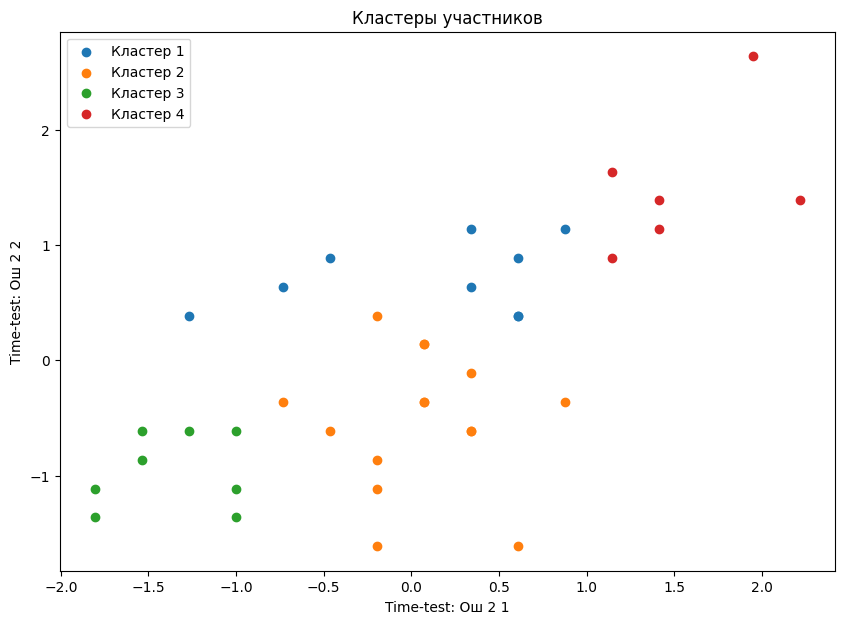

In [36]:
# Оптимальное количество кластеров (например, 2)
optimal_clusters = 4

# Иерархическая кластеризация с двумя кластерами
agglo = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
clusters = agglo.fit_predict(X_scaled)

# Добавление кластеров в данные
data['Cluster'] = clusters

# Построение двумерного графика
plt.figure(figsize=(10, 7))
for cluster in range(optimal_clusters):
    plt.scatter(
        X_scaled[clusters == cluster, 0],
        X_scaled[clusters == cluster, 1],
        label=f'Кластер {cluster + 1}'
    )
plt.title('Кластеры участников')
plt.xlabel(variables[0])
plt.ylabel(variables[1])
plt.legend()
plt.show()


In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# Загрузка данных
file_path = "/content/gdrive/My Drive/working_memory/conference_without_blinks.csv"  # Замените на путь к вашему файлу
data = pd.read_csv(file_path)

# Выбор переменных для кластеризации
cluster_variables = ['Time-test: Ош 2 1',
                      'Time-test: Ош 2 2',]

# Стандартизация данных для кластеризации
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data[cluster_variables].values)

# Иерархическая кластеризация (используем оптимальное число кластеров - 3)
optimal_clusters = 4
agglo = AgglomerativeClustering(n_clusters=optimal_clusters, metric='euclidean', linkage='ward')
clusters = agglo.fit_predict(X_scaled)

# Добавление кластеров в исходные данные
data['Cluster'] = clusters

# Переменные, которые вы хотите проанализировать
variables_of_interest = [
    'WMem: Количество объектов, серия 1',
    'WMem: Количество объектов, серия 2',
    'WMem: Количество объектов, серия 3',
    'Time-test: Ош 2 1',
    'Time-test: Ош 2 2',
    'Сколько лет вашему ребенку, принимавшему участие в исследовании ?',
    'пол',
    'У вашего ребёнка есть собственные цифровые устройства?',
    'будние дни',
    'Выходные'
]

# Создание пустого DataFrame для хранения результатов
cluster_stats = pd.DataFrame(index=variables_of_interest, columns=[f"Cluster {i+1}" for i in range(optimal_clusters)])

# Вычисление средних значений и стандартных отклонений по каждому кластеру
for var in variables_of_interest:
    for i in range(optimal_clusters):
        cluster_data = data[data['Cluster'] == i][var]
        mean = cluster_data.mean()
        std = cluster_data.std()
        cluster_stats.loc[var, f"Cluster {i+1}"] = f"{mean:.2f} ± {std:.2f}"

# Сохранение результатов в CSV файл
output_file = "/content/gdrive/My Drive/working_memory/cluster_statistics_selected_variables.csv"
cluster_stats.to_csv(output_file, encoding='utf-8')

print(f"Результаты успешно сохранены в файл {output_file}")

Результаты успешно сохранены в файл /content/gdrive/My Drive/working_memory/cluster_statistics_selected_variables.csv
